# Epidemiological Model Assignment — Parameter exploration
### Understanding disease dynamics
## Overview
1. **Setup & Imports**
2. **Part 1: Parameter Analysis Function**
3. **Part 2: Scenario Comparison**
4. **Part 3: Policy Recommendations**
5. **Conclusions**

## Required Libraries

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import odeint
import seaborn as sns

## Assignment task: Recovery rate investigation

Using the **SIRD model** from your practical as a starting point, you will investigate how the recovery rate affects epidemic outcomes.

# Part 1: Parameter analysis function

**Task**: Create a function called *analyze_recovery_rates()* that systematically explores different recovery rates.

### 1.1 Function implementation

In [5]:
def analyze_recovery_rates(beta, mu, N, I0, simulation_days):
    """
    Analyze epidemic outcomes for different recovery rates.

    Parameters:
    -----------
    beta : float
        Transmission rate
    mu : float
        Mortality rate
    N : int
        Total population
    I0 : int
        Initial infected individuals
    simulation_days : int
        Simulation duration in days

    Returns:
    --------
    pandas.DataFrame
        Results summary for each recovery rate
    """
    gamma_values = [0.05, 0.1, 0.15, 0.2, 0.25]

    def _sird(y, t, beta, gamma, mu, N):
        S, I, R, D = y
        dSdt = -beta * S * I / N
        dIdt = beta * S * I / N - gamma * I - mu * I
        dRdt = gamma * I
        dDdt = mu * I
        return [dSdt, dIdt, dRdt, dDdt]

    t = np.arange(0, simulation_days + 1, 1.0)
    records = []

    fig, ax = plt.subplots(figsize=(8, 5))
    for gamma in gamma_values:
        S0, R0, D0 = N - I0, 0.0, 0.0
        y0 = [S0, float(I0), R0, D0]
        sol = odeint(_sird, y0, t, args=(beta, gamma, mu, N))
        S, I, R, D = sol.T

        peak_idx = int(np.argmax(I))
        records.append({
            'gamma': gamma,
            'R0': float(beta / gamma),
            'peak_infected': float(I[peak_idx]),
            'peak_day': int(t[peak_idx]),
            'total_deaths': float(D[-1])
        })

        ax.plot(t, I, label=f'γ={gamma:.2f} (R₀={beta/gamma:.2f})')

    ax.set_title('SIRD Infectious Curves for Different Recovery Rates γ')
    ax.set_xlabel('Days')
    ax.set_ylabel('Number of infectious individuals I(t)')
    ax.legend(title='Recovery rate scenarios')
    ax.grid(True)
    fig.tight_layout()
    plt.show()

    df = pd.DataFrame(records, columns=['gamma', 'R0', 'peak_infected', 'peak_day', 'total_deaths'])
    return df.sort_values('gamma').reset_index(drop=True)


# Part 2: Scenario comparison

This is the output of the function we defined early with the parameters provided.

Scenario A - High Transmission:


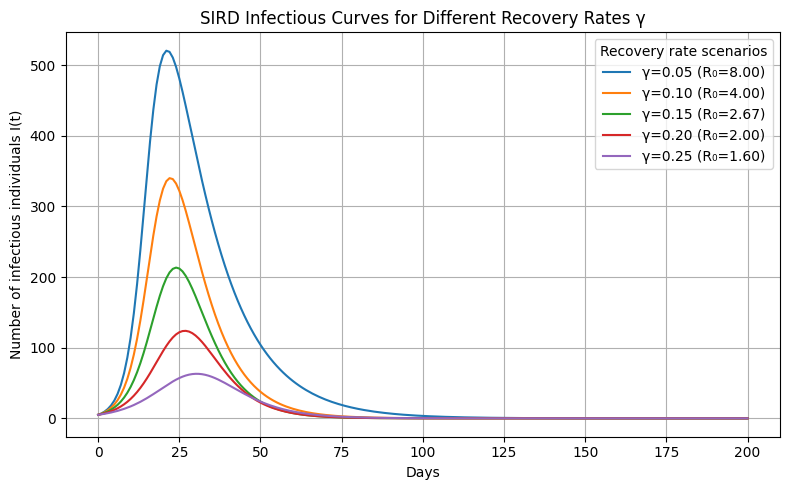

Scenario B - Low Transmission:


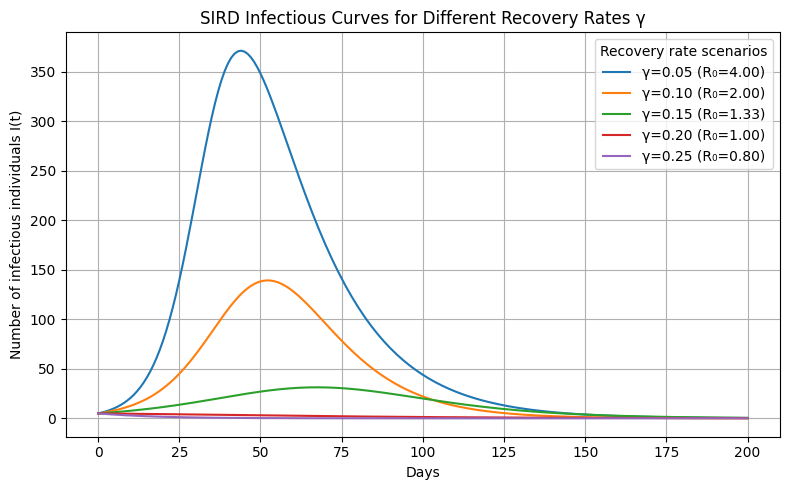

In [6]:
print("Scenario A - High Transmission:")
df_A = analyze_recovery_rates(beta=0.4, mu=0.02,  N=1000, I0=5, simulation_days=200)
print("Scenario B - Low Transmission:")
df_B = analyze_recovery_rates(beta=0.2, mu=0.005, N=1000, I0=5, simulation_days=200)

In [7]:
print("Scenario A - High Transmission:")
display(df_A[['gamma','R0','peak_infected','peak_day','total_deaths']])
print("Scenario B - Low Transmission:")
display(df_B[['gamma','R0','peak_infected','peak_day','total_deaths']])


Scenario A - High Transmission:


,gamma,R0,peak_infected,peak_day,total_deaths
0,0.05,8.000000,520.582635,21,284.757434
1,0.10,4.000000,340.140583,22,159.892366
2,0.15,2.666667,213.465894,24,102.610885
3,0.20,2.000000,123.893909,27,67.423926
4,0.25,1.600000,63.051893,30,42.694003


Scenario B - Low Transmission:


,gamma,R0,peak_infected,peak_day,total_deaths
0,0.05,4.000000,371.356334,44,88.225824
1,0.10,2.000000,139.333450,52,36.700237
2,0.15,1.333333,31.340756,67,13.642779
3,0.20,1.000000,5.000000,0,1.832013
4,0.25,0.800000,5.000000,0,0.433167


### Combined visualization

We plot total deaths against recovery rate γ for both scenarios to visually compare how increasing γ reduces deaths in high and low transmission settings.

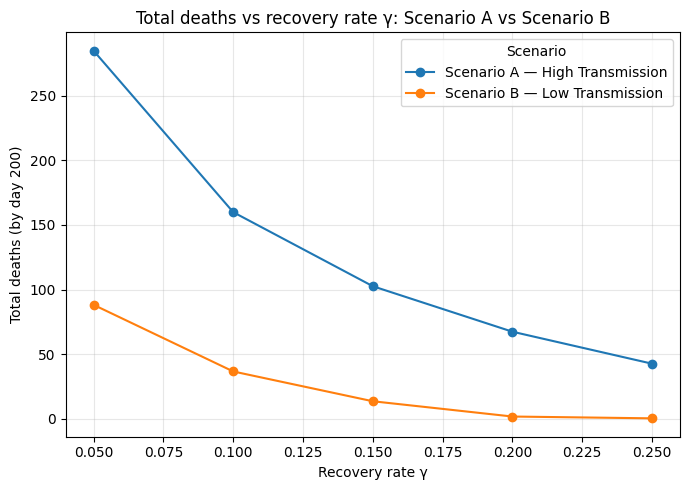

In [8]:
A = df_A.sort_values('gamma')
B = df_B.sort_values('gamma')

fig, ax = plt.subplots(figsize=(7,5))
ax.plot(A['gamma'], A['total_deaths'], marker='o', label='Scenario A — High Transmission')
ax.plot(B['gamma'], B['total_deaths'], marker='o', label='Scenario B — Low Transmission')

ax.set_xlabel('Recovery rate γ')
ax.set_ylabel('Total deaths (by day 200)')
ax.set_title('Total deaths vs recovery rate γ: Scenario A vs Scenario B')
ax.legend(title='Scenario')
ax.grid(True, alpha=0.3)
plt.tight_layout()


### Interpretation: Scenario A vs. Scenario B

Across all tested recovery rates γ, Scenario A with a high transmission consistently results in more deaths than Scenario B which has a low transmission. For example, at γ = 0.15, the model reports approximately 103 deaths in Scenario A versus approximately 14 in Scenario B; at γ = 0.25, the model reports approximately 43 deaths in Scenario A versus fewer than one in Scenario B.  

Two mechanisms explain this difference:
- Higher β in A means that each infectious person causes more new cases.  
- Higher μ in A means that deaths accumulate faster, since dD/dt = μ·I(t).  

Because R₀ = β/γ Scenario A always has a higher reproduction number at the same γ. This means that outbreaks in Scenario A grow more easily and persist for longer before recovery slows transmission.

In Scenario B, once γ ≥ 0.20, R₀ ≤ 1. Infections die out quickly and total deaths remain low. In Scenario A, R₀ remains greater than 1 across the entire tested range, resulting in ongoing outbreaks. The combined plot reflects this because the A curve lies above the B curve at every γ value, but the gap shrinks as γ increases and does not close completely.

### 2.1 Scenario analysis

# Part 3: Policy recommendations

We now quantify the effect of increasing the recovery rate γ on outcomes, evaluate a +50% γ intervention in Scenario A and provide a concrete, real-world example of how to raise γ.

### 3.1 Parameter impact analysis (use your tables `df_A` and `df_B`)

As γ increases, **R₀ = β/γ** decreases; peak infections and total deaths should **drop**, and peak timing may **shift**. The code below summarizes the change from the **lowest** to the **highest** tested γ for each scenario. Use the printed numbers to support your sentences.

In [8]:
import numpy as np
import pandas as pd

def summarize_gamma_span(df: pd.DataFrame):
    """
    Summarize the effect of changing recovery rate γ on epidemic outcomes.

    Parameters:
    -----------
    df : pandas.DataFrame
        Table of SIRD results for different γ values. Must contain columns:
        ['gamma', 'R0', 'peak_infected', 'peak_day', 'total_deaths']

    Returns:
    --------
    pandas.Series
        Summary statistics comparing lowest and highest γ:
        - gamma_min, gamma_max
        - R0_at_min_gamma, R0_at_max_gamma
        - peak_I_at_min, peak_I_at_max, peak_I_pct_drop
        - deaths_at_min, deaths_at_max, deaths_pct_drop
        - peak_day_at_min, peak_day_at_max
    """
    s = df.sort_values('gamma').reset_index(drop=True)
    lo, hi = s.iloc[0], s.iloc[-1]
    print( pd.Series({
        'gamma_min'            : float(lo['gamma']),
        'gamma_max'            : float(hi['gamma']),
        'R0_at_min_gamma'      : float(lo['R0']),
        'R0_at_max_gamma'      : float(hi['R0']),
        'peak_I_at_min'        : float(lo['peak_infected']),
        'peak_I_at_max'        : float(hi['peak_infected']),
        'peak_I_pct_drop'      : 100.0 * (lo['peak_infected'] - hi['peak_infected']) / max(lo['peak_infected'], 1e-9),
        'deaths_at_min'        : float(lo['total_deaths']),
        'deaths_at_max'        : float(hi['total_deaths']),
        'deaths_pct_drop'      : 100.0 * (lo['total_deaths'] - hi['total_deaths']) / max(lo['total_deaths'], 1e-9),
        'peak_day_at_min'      : int(lo['peak_day']),
        'peak_day_at_max'      : int(hi['peak_day']),
    }))

print('df_A')
summarize_gamma_span(df_A)
print('df_B')
summarize_gamma_span(df_B)

df_A
gamma_min            0.050000
gamma_max            0.250000
R0_at_min_gamma      8.000000
R0_at_max_gamma      1.600000
peak_I_at_min      520.582635
peak_I_at_max       63.051893
peak_I_pct_drop     87.888207
deaths_at_min      284.757434
deaths_at_max       42.694003
deaths_pct_drop     85.006887
peak_day_at_min     21.000000
peak_day_at_max     30.000000
dtype: float64
df_B
gamma_min            0.050000
gamma_max            0.250000
R0_at_min_gamma      4.000000
R0_at_max_gamma      0.800000
peak_I_at_min      371.356334
peak_I_at_max        5.000000
peak_I_pct_drop     98.653584
deaths_at_min       88.225824
deaths_at_max        0.433167
deaths_pct_drop     99.509025
peak_day_at_min     44.000000
peak_day_at_max      0.000000
dtype: float64


### 3.2 Intervention analysis (Scenario A, +50% γ)

We take γ from **0.10** to **0.15** in Scenario A (both values are in your `df_A` table). The code below reads the two rows and reports the change in **total deaths**, **peak infections**, **peak day**, and **R₀**.


In [ ]:
base_gamma = 0.10
new_gamma  = 0.15
def pick_row(df, g):
    """
    Select the row in the DataFrame with the γ value closest to the target.

    Parameters:
    -----------
    df : pandas.DataFrame
        Table of SIRD results for different γ values.
    g : float
        Target recovery rate γ.

    Returns:
    --------
    pandas.Series
        Row corresponding to the nearest γ value.
    """
    return df.iloc[(df['gamma'] - g).abs().argsort().iloc[0]]

row_base = pick_row(df_A, base_gamma)
row_new  = pick_row(df_A, new_gamma)

deaths_base = float(row_base['total_deaths'])
deaths_new  = float(row_new['total_deaths'])
deaths_abs  = deaths_new - deaths_base
deaths_pct  = 100.0 * deaths_abs / max(deaths_base, 1e-9)

peak_base   = float(row_base['peak_infected'])
peak_new    = float(row_new['peak_infected'])
peak_abs    = peak_new - peak_base
peak_pct    = 100.0 * peak_abs / max(peak_base, 1e-9)

print(f"Scenario A: γ {float(row_base['gamma']):.2f} → {float(row_new['gamma']):.2f}")
print(f"R₀: {float(row_base['R0']):.2f} → {float(row_new['R0']):.2f}")
print(f"Total deaths: {deaths_base:.2f} → {deaths_new:.2f}  (Δ {deaths_abs:.2f}, {deaths_pct:.1f}%)")
print(f"Peak infected: {peak_base:.1f} → {peak_new:.1f}  (Δ {peak_abs:.1f}, {peak_pct:.1f}%)")
print(f"Peak day: {int(row_base['peak_day'])} → {int(row_new['peak_day'])}")


Scenario A: γ 0.10 → 0.15
R₀: 4.00 → 2.67
Total deaths: 159.89 → 102.61  (Δ -57.28, -35.8%)
Peak infected: 340.1 → 213.5  (Δ -126.7, -37.2%)
Peak day: 22 → 24


**One‑sentence takeaway:**  
Increasing γ by 50% in Scenario A (0.10 → 0.15) lowers R₀ from 4.00 to 2.67, reduces total deaths from **159.89** to **102.61** (**−35.8%**), shrinks the peak from **340.14** to **213.47** (**−37.2%**), and shifts the peak day from **22** to **24**. 


### 3.3 Real‑world application (how to increase γ)

**Example:** **Early antiviral therapy** for suitable viral infections.  
**Mechanism:** inhibits viral replication, shortens illness duration, and speeds movement from Infectious → Recovered, effectively **raising γ** in the SIRD model.  
**Realistic effectiveness:** clinical programs that shorten the average recovery time by about **20–50%** (e.g., from 10 days to 7–8 days) correspond to meaningful increases in γ and, as shown above, substantial reductions in peak size and total deaths.


Conclusions:

- Raising the recovery rate γ consistently reduces R₀, peak infections and total deaths.  
- Scenario A remains worse than Scenario B at every tested γ value. Across the range of γ values from 0.05 to 0.25, the total number of deaths in high transmission drops from 284.8 to 42.7 (−85%), while the total number of deaths in low transmission drops from 88.2 to 0.43 (−99.5%).  
- When γ ≥ 0.20, Scenario B crosses the epidemic threshold (R₀ ≤ 1), causing infections to die out quickly. In contrast, Scenario A still has R₀ > 1 over the tested range, resulting in larger outbreaks.  
- Policy implication: interventions that shorten the duration of illness, increasing γ, can substantially lower the number of deaths, especially when transmission (β) cannot be reduced enough to push R₀ below